In [ ]:
import torch
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import SubsetRandomSampler

import torchsummary

import numpy as np
import matplotlib.pyplot as plt

CIFAR dataset
- data augmentation : mirroring/shifting (CIFAR +)
- preprocessing : channel means/standard deviations.
- training set : 45000
- validation set : 5000
- test set : 10000

Training
- SGD
- batch size : 64
- epochs : 300
- init lr : 0.1
    - epochs의 0.5(150), 0.75(225) 지점에서 10으로 나눔
- weight decay : $10^{-4}$
- Nesterov momentum : 0.9
- init weight : He
- dropout : 0.2 (data augmentation 안 한 경우)

In [ ]:
batch_size = 64
epochs = 300
init_lr = 0.1

weight_decay = 1e-4
momentum = 0.9

validation_ratio = 0.1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
transform_train = transforms.Compose(
    [
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_validation = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

vaildation_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_validation)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat',
           4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
num_classes = len(classes)

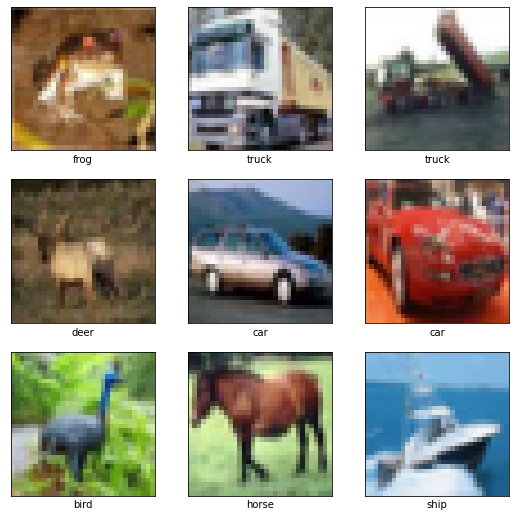

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows = 3
cols = 3
idx = 1

for i in range(9):
    image = train_set.data[i]
    target = classes[train_set.targets[i]]
    ax = fig.add_subplot(rows, cols, idx)
    ax.imshow(image)
    ax.set_xlabel(target)
    ax.set_xticks([]), ax.set_yticks([])
    idx += 1

plt.show()

In [ ]:
train_num = len(train_set)
indices = list(range(train_num))
split = int(np.floor(validation_ratio * train_num))

np.random.shuffle(indices)

In [ ]:
train_idx, validation_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size,
    sampler = train_sampler, 
)

validation_loader = torch.utils.data.DataLoader(
    vaildation_set, batch_size=batch_size,
    sampler=validation_sampler
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False
)

<img src='https://hoya012.github.io/assets/img/densenet/4.png'>

참조 : [DenseNet Tutorial [1] Paper Review & Implementation details](https://hoya012.github.io/assets/img/densenet/4.png)


In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_classes, growth_rate, depth, theta=0.5, bottleneck=False, init_weights=True):
        super(DenseNet, self).__init__()
        self.bottleneck = bottleneck
        self.growth_rate = growth_rate
        
        n_DenseBlocks = (depth - 4) // 3
        if bottleneck:
            n_DenseBlocks //= 2

        if bottleneck:
            self.init_conv = nn.Conv2d(in_channels=3, out_channels=2*growth_rate, kernel_size=3, padding=1)
            self.out_channels = 2*growth_rate
        else:
            self.init_conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
            self.out_channels = 16

        # 32 x 32 이미지
        self.dense1 = self._make_dense(n_DenseBlocks)
        
        if bottleneck:
            self.trans1 = TransitionLayer(self.out_channels, 0.5, True)
            self.out_channels = int(np.floor(self.out_channels * theta))
        else:
            self.trans1 = TransitionLayer(self.out_channels)

        # 16 x 16 이미지
        self.dense2 = self._make_dense(n_DenseBlocks)
        
        if bottleneck:
            self.trans2 = TransitionLayer(self.out_channels, 0.5, True)
            self.out_channels = int(np.floor(self.out_channels * theta))
        else:
            self.trans2 = TransitionLayer(self.out_channels)
        
        # 8 x 8 이미지
        self.dense3 = self._make_dense(n_DenseBlocks)

        self.fc_layer = nn.Linear(self.out_channels, num_classes)
        
        if init_weights:
            self._init_weights()

    def forward(self, x):
        out = self.init_conv(x)
        out = self.dense1(out)
        out = self.trans1(out)
        out = self.dense2(out)
        out = self.trans2(out)
        out = self.dense3(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def _make_dense(self, n_DenseBlocks):
        in_channels = self.out_channels
        growth_rate = self.growth_rate
        layers = []

        for i in range(n_DenseBlocks):
            if self.bottleneck:
                layers.append(Bottleneck(in_channels, growth_rate))
            else:
                layers.append(SingleLayer(in_channels, growth_rate))

            in_channels += growth_rate
            self.out_channels += growth_rate  
        
        return nn.Sequential(*layers)

In [ ]:
class TransitionLayer(nn.Module):
    '''
    A Batch Normalization layer and an 1×1 Convolutional Layer followed by a 2×2 Average Pooling Layer.
    set theta = 0.5
    '''
    def __init__(self, in_channels, theta=0.5, bottleneck=False):
        super(TransitionLayer, self).__init__()

        out_channels = in_channels
        if bottleneck:
            out_channels = int(np.floor(in_channels * theta))
            
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1x1(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, kernel_size=2)
        return out

In [ ]:
class Bottleneck(nn.Module):
    '''
    DenseNet-BC Model
    '''
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        inter_channels = 4 * growth_rate
        
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1x1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv3x3 = nn.Conv2d(inter_channels, growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1x1(F.relu(self.bn1(x)))
        out = self.conv3x3(F.relu(self.bn2(out)))
        return torch.cat((x, out), 1)

In [ ]:
class SingleLayer(nn.Module):
    '''
    DenseNet Model
    '''
    def __init__(self, in_channels, growth_rate):
        super(SingleLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        return torch.cat((x, out), 1)

In [ ]:
def DenseNet_40_12():
    net = DenseNet(num_classes=num_classes, growth_rate=12, depth=40)
    return net

In [ ]:
def DenseNet_100_12():
    net = DenseNet(num_classes=num_classes, growth_rate=12, depth=100)
    return net

In [ ]:
def DenseNet_100_24():
    net = DenseNet(num_classes=num_classes, growth_rate=24, depth=100)
    return net

In [ ]:
def DenseNet_BC_100_12():
    net = DenseNet(num_classes=num_classes, growth_rate=12, depth=100, bottleneck=True)
    return net

In [ ]:
def DenseNet_BC_250_24():
    net = DenseNet(num_classes=num_classes, growth_rate=24, depth=250, bottleneck=True)
    return net

In [ ]:
def DenseNet_BC_190_40():
    net = DenseNet(num_classes=num_classes, growth_rate=40, depth=190, bottleneck=True)
    return net

In [ ]:
net = DenseNet_BC_100_12()
net.to(device)

DenseNet(
  (init_conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1x1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3x3): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1x1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3x3): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1x1): Conv2d(48, 48, kernel_size=(1

In [ ]:
torchsummary.summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             672
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,200
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,196
        Bottleneck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,776
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,196
       Bottleneck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,352
      BatchNorm2d-14           [-1, 48,

![image.png](https://sike6054.github.io/blog/images/DenseNet,%20Table.2(removed).png)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs * 0.5), int(epochs * 0.75)])

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):  
    lr_scheduler.step()
    
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    steps = len(train_loader)
    print('[epoch : %d/%d] train loss : %.5f\ttrain acc : %d %%\t' %
            (epoch + 1, epochs, running_loss / steps, 100 * correct / total), end = '')
    train_loss.append(running_loss / steps)
    train_acc.append(100 * correct / total)
    running_loss = 0.0
        
    # validation part
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    steps = len(validation_loader) 
    print('val loss : %.5f\tval acc: %d %%' % 
          (running_loss /steps, 100 * correct / total)
         )
    val_loss.append(running_loss /steps)
    val_acc.append(100 * correct / total)

print('Finished Training')

[epoch : 1/300] train loss : 0.58338	train acc : 79 %	val loss : 0.48906	val acc: 83 %
[epoch : 2/300] train loss : 0.53354	train acc : 81 %	val loss : 0.44992	val acc: 84 %
[epoch : 3/300] train loss : 0.49903	train acc : 82 %	val loss : 0.37543	val acc: 86 %
[epoch : 4/300] train loss : 0.45784	train acc : 84 %	val loss : 0.35188	val acc: 87 %
[epoch : 5/300] train loss : 0.44757	train acc : 84 %	val loss : 0.35421	val acc: 87 %
[epoch : 6/300] train loss : 0.42798	train acc : 85 %	val loss : 0.30650	val acc: 89 %
[epoch : 7/300] train loss : 0.41431	train acc : 85 %	val loss : 0.33920	val acc: 87 %
[epoch : 8/300] train loss : 0.40318	train acc : 86 %	val loss : 0.29668	val acc: 89 %
[epoch : 9/300] train loss : 0.39028	train acc : 86 %	val loss : 0.27420	val acc: 90 %
[epoch : 10/300] train loss : 0.39087	train acc : 86 %	val loss : 0.29814	val acc: 89 %
[epoch : 11/300] train loss : 0.37208	train acc : 87 %	val loss : 0.27752	val acc: 90 %
[epoch : 12/300] train loss : 0.36340	tra

In [ ]:
num_epochs = range(epochs)

plt.plot(num_epochs, train_acc, 'bo', label='Training acc')
plt.plot(num_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(num_epochs, train_loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
                
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))            
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i])) 